https://archive.ics.uci.edu/ml/datasets/student+performance

In [1]:
# A - with all variables from Table 1 except G3 (the
# output);
# B - similar to A but without G2 (the second period
# grade); and
# C - similar to B but without G1 (the first period

# 1. Binary classification – pass if G310, else fail;
# 2. 5-Level classification – based on the Erasmus1
# grade conversion system (Table 2);
# 3. Regression – the G3 value (numeric output between
# 0 and 20).


# Table 2: The five-level classification system
# I II III IV V
# Country (excellent/very good) (good) (satisfactory) (sufficient) (fail)
# Portugal/France 16-20 14-15 12-13 10-11 0-9
# Ireland A B C D F

In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.utils import shuffle
from scipy.stats import ranksums
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import warnings
from math import log2

def KFoldCV(model, data, n_fold=10):
#     num = len(data)
    diff = int(len(data)/n_fold)
    results = np.zeros((n_fold, 4))
    for i in range(n_fold):
        begin = diff*i
        end = diff*(i+1)
#         if i == n_fold-1:
#             end = -1
        test = data[begin:end]
        train = deepcopy(data)
        train = np.delete(train, range(begin, end),axis=0)
        X_train, y_train = train[:,:-1], train[:,-1]
        X_test, y = test[:,:-1], test[:,-1]
        predictY = model.fit(X_train, y_train).predict(X_test)
        mae = np.mean(abs((y-predictY)))
        stdErr = np.std(((y-predictY)))
        error=sum((y-predictY)**2)
        RMSE=np.sqrt(error/len(y))
        MAC = np.dot(y,predictY)**2/(np.dot(y, y)*np.dot(predictY, predictY))
#         print(mae, stdErr, RMSE, MAC)
        results[i,:] = [mae, stdErr, RMSE, MAC]
    return results

warnings.filterwarnings('ignore')

# data = pd.read_csv('./student-mat.csv', sep=';')
# por = pd.read_csv('./student-por.csv', sep=';')
# combine = pd.merge(math, por, on=["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"])
# data = data.values
# data = shuffle(data)

In [79]:
data = pd.read_csv('./student-por.csv', sep=';')
cats = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
oe = OrdinalEncoder()
for c in cats:
    oe.fit(data[c].values.reshape(-1,1))
    data[c] = np.asarray(oe.transform(data[c].values.reshape(-1,1)),dtype=int)
#     np.asarray(data['gender'],dtype=int)
data = data.values
data = shuffle(data)

In [80]:
# data.shape (395, 33)
# np.savetxt('math.txt',data)
data.shape

(649, 33)

# G3

In [67]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

# F(x) = F'(x) + Error(x)
# F(x) = F'(x) + noise * Error(x)
# F(x) = weighted * F'(x) + noise * Error(x)
# train F'(x)
# train Error(x)

def gridSearch4CatBoost(X,y,n_estimators,max_depth):
#     cbc = CatBoostRegressor(verbose=False,task_type="GPU",devices='0:1')
# #     cbc = RandomForestRegressor()
#     grid = {'max_depth': [3,4,5],'n_estimators':[100,300,500]}
#     gscv = GridSearchCV (estimator = cbc, param_grid = grid, cv = 10)
#     gscv.fit(X,y)
#     return gscv.best_estimator_
    return CatBoostRegressor(verbose=False,task_type="GPU",devices='0:1',n_estimators=n_estimators,max_depth=max_depth).fit(X,y)

def KFoldCV2(data,n_estimators,max_depth, n_fold=10):
#     num = len(data)
    diff = int(len(data)/n_fold)
    results = np.zeros((n_fold, 4))
    for i in range(n_fold):
        begin = diff*i
        end = diff*(i+1)
        if i == n_fold-1:
            end = -1
        test = data[begin:end]
        train = deepcopy(data)
        train = np.delete(train, range(begin, end),axis=0)
        X_train, y_train = train[:,:-1], train[:,-1]
        X_test, y = test[:,:-1], test[:,-1]
#        gridSearch4CatBoost grid search for F'(x) and Error(x)
        model = gridSearch4CatBoost(X_train, y_train,n_estimators,max_depth)
        errorY = y_train - model.predict(X_train)
#         model = gridSearch4CatBoost(np.hstack((X_train,errorY.reshape((len(errorY),1)))), y_train,n_estimators,max_depth)
#         errorYBi = [1 if i > 0 else -1 for i in errorY]
#         modelDir = CatBoostClassifier(verbose=False,task_type="GPU",devices='0:1',n_estimators=n_estimators,max_depth=max_depth).fit(X_train, errorYBi)
#         yDir = modelDir.predict(X_train)
#         print(yDir)
        predictYe = gridSearch4CatBoost(X_train, errorY,n_estimators,max_depth).predict(X_test)
#         predictYe = gridSearch4CatBoost(X_train, errorY,n_estimators,max_depth).predict(np.hstack((X_test,predictYe))
#         predictYdir = modelDir.predict(X_test)
#         predictYp = model.predict(np.hstack((X_test,predictYe.reshape((len(predictYe),1)))))
        predictYp = model.predict(X_test)
        predictY = predictYp + predictYe#*predictYdir
#         predictY = predictY.astype(int)
#         print(predictYe)
#         print(predictYp)
#         print(predictY)
#         print(y)
        mae = np.mean(abs((y-predictY)))
        stdErr = np.std(y-predictY)
        error=sum((y-predictY)**2)
        RMSE=np.sqrt(error/len(y))
        MAC = np.dot(y,predictY)**2/(np.dot(y, y)*np.dot(predictY, predictY))
#         print(mae, stdErr, RMSE, MAC)
        results[i,:] = [mae, stdErr, RMSE, MAC]
    return results

n_estimators= [100,300,500]
max_depth = [3,4, 5]
n_estimators  = [500]
max_depth = [3]
epochs=20
cats = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            result = KFoldCV2(data,i,j)
            cats[epoch,:] = np.mean(result, axis=0)
        print(np.mean(cats, axis=0))

[0.71955487 1.0156176  1.02464105 0.98781661]


In [68]:
cats

array([[0.73172087, 1.02012446, 1.03729315, 0.98738658],
       [0.70439686, 0.99022157, 0.99650811, 0.98851429],
       [0.69788628, 0.97333973, 0.98164016, 0.98852148],
       [0.73469545, 1.04833049, 1.05371143, 0.98678666],
       [0.73677586, 1.03651886, 1.04638263, 0.98730323],
       [0.70650262, 0.97749727, 0.98508927, 0.98868344],
       [0.71698385, 1.02446125, 1.02889083, 0.98751082],
       [0.7102275 , 0.99222781, 1.00068598, 0.98860705],
       [0.71627314, 1.01999884, 1.02580227, 0.98799708],
       [0.71778814, 1.00233733, 1.01122714, 0.98820171],
       [0.72071872, 1.01401425, 1.02110258, 0.98801301],
       [0.71161727, 1.01140177, 1.02065822, 0.98804811],
       [0.73133469, 1.05069836, 1.05700305, 0.98697243],
       [0.71848096, 1.00766   , 1.01979891, 0.98812742],
       [0.71979889, 1.03419955, 1.04555757, 0.98775624],
       [0.73282142, 1.04211805, 1.04998614, 0.98707389],
       [0.7258568 , 1.03330256, 1.04012936, 0.98745435],
       [0.7084359 , 1.00552327,

# G3 binary classification

In [81]:
# # G3
# # data = data[:,:-1]
# data[:,-1] = [0 if x <10 else 1 for x in data[:,-1]]

In [82]:
hidden_layer_sizes  = [100, 300, 500]
max_iter = [500, 1000,1500]
hidden_layer_sizes  = [100]
max_iter = [500]
epochs=20
mlps = np.zeros((epochs,4))
for i in hidden_layer_sizes:
    for j in max_iter:
        for epoch in range(epochs):
            data = shuffle(data)
            model = MLPRegressor(hidden_layer_sizes=i, max_iter=j)
            result = KFoldCV(model, data)
            mlps[epoch,:] = np.mean(result, axis=0)
#             print(np.mean(result, axis=0))
        print(np.mean(mlps, axis=0))
mlps

[0.80595764 1.12232072 1.13129282 0.98523058]


array([[0.79078832, 1.09729382, 1.10843011, 0.98633097],
       [0.81517514, 1.15005579, 1.15831823, 0.98485598],
       [0.78721414, 1.10964661, 1.11977573, 0.98581276],
       [0.79744052, 1.09884692, 1.10865264, 0.98537164],
       [0.79713483, 1.12717005, 1.13452538, 0.98499425],
       [0.82514316, 1.16656086, 1.17388738, 0.98406489],
       [0.81033583, 1.1360358 , 1.14101015, 0.98483475],
       [0.84655335, 1.18246854, 1.1917545 , 0.98378312],
       [0.81770408, 1.13809671, 1.14758059, 0.98497541],
       [0.80353856, 1.12493884, 1.13584471, 0.98522065],
       [0.7954482 , 1.10387246, 1.10828159, 0.98578629],
       [0.80876618, 1.13827854, 1.14687909, 0.98448695],
       [0.83237374, 1.16592367, 1.17251778, 0.98399182],
       [0.78496817, 1.1087211 , 1.12132066, 0.98563161],
       [0.81167466, 1.10030687, 1.11478903, 0.98503533],
       [0.79421926, 1.09530906, 1.10426694, 0.98602024],
       [0.78759038, 1.07668453, 1.08523292, 0.98653027],
       [0.83234862, 1.13846958,

In [83]:
Cs = [10, 100, 1000]
gammas = [0.001, 0.01, 0.1]
Cs = [100]
gammas = [0.001]
svms = np.zeros((epochs,4))
for i in range(len(Cs)):
    for j in range(len(gammas)):
        lc = len(Cs)
        lg = len(gammas)
        for epoch in range(epochs):
            data = shuffle(data)
            model = SVR(kernel = 'rbf', C = Cs[i], gamma = gammas[j])
            result = KFoldCV(model, data)
            svms[epoch,:] = np.mean(result, axis=0)
        print(np.mean(svms, axis=0))
svms

[0.76236296 1.05130763 1.06248783 0.9869681 ]


array([[0.76216227, 1.04863386, 1.05735946, 0.98662482],
       [0.7487965 , 1.04502922, 1.05302634, 0.98739833],
       [0.7709122 , 1.06200827, 1.07146292, 0.98677459],
       [0.77331201, 1.0559315 , 1.07076082, 0.98689988],
       [0.76603367, 1.05068657, 1.0621524 , 0.98687457],
       [0.75857288, 1.03609673, 1.05218144, 0.98709384],
       [0.76515634, 1.06378477, 1.07281422, 0.98690016],
       [0.76226495, 1.05005342, 1.06219312, 0.98695758],
       [0.75452947, 1.02351297, 1.0346292 , 0.98700455],
       [0.76783115, 1.04736042, 1.05735275, 0.98701527],
       [0.75259532, 1.05318241, 1.06726809, 0.98720432],
       [0.75779105, 1.03525562, 1.04660595, 0.9868721 ],
       [0.77407163, 1.06315504, 1.07532897, 0.98674589],
       [0.76676137, 1.05409325, 1.0736749 , 0.98704804],
       [0.75516964, 1.05268119, 1.05739522, 0.98709604],
       [0.76169217, 1.05723478, 1.06918882, 0.98711077],
       [0.75531758, 1.05157017, 1.06064102, 0.98710241],
       [0.77081674, 1.06880328,

In [84]:
n_estimators  = [100, 300, 500]
max_depth = [3, 4, 5]
n_estimators  = [300]
max_depth = [4]
rfs = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            model = RandomForestRegressor(n_estimators=i, max_depth=j)
            result = KFoldCV(model, data)
            rfs[epoch,:] = np.mean(result, axis=0)
        print(np.mean(rfs, axis=0))
rfs

[0.72835917 1.0376166  1.04687727 0.98729754]


array([[0.72858213, 1.02540662, 1.03698042, 0.98770597],
       [0.73762917, 1.02334107, 1.04156753, 0.98711966],
       [0.72288171, 1.03662636, 1.04176424, 0.98728021],
       [0.72947069, 1.02394603, 1.0343172 , 0.98741076],
       [0.7318178 , 1.04741251, 1.05864285, 0.98730347],
       [0.72612331, 1.0391893 , 1.04822726, 0.9874095 ],
       [0.72150543, 1.01637357, 1.03662967, 0.98783668],
       [0.73940341, 1.05459804, 1.05878476, 0.98702451],
       [0.71988806, 1.01031438, 1.01880963, 0.98777232],
       [0.72514375, 1.04079793, 1.0448773 , 0.98749902],
       [0.7372641 , 1.0578224 , 1.0650701 , 0.98697454],
       [0.72657178, 1.05278573, 1.05552411, 0.98713475],
       [0.72786055, 1.04801947, 1.05819548, 0.98739706],
       [0.72259856, 1.02945573, 1.04376778, 0.98734581],
       [0.71721366, 1.02874628, 1.03299865, 0.9871187 ],
       [0.72584315, 1.04444074, 1.05274898, 0.98733965],
       [0.71993523, 1.02925159, 1.03560901, 0.98776397],
       [0.725432  , 1.04852599,

In [85]:
n_estimators= [100, 300, 500]
max_depth = [3, 4, 5]
n_estimators  = [100]
max_depth = [3]
xgbs = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            model = XGBRegressor(n_estimators=i, max_depth=j)
            result = KFoldCV(model, data)
            xgbs[epoch,:] = np.mean(result, axis=0)
        print(np.mean(xgbs, axis=0))
xgbs

[0.80123462 1.11776777 1.12888984 0.98544724]


array([[0.79969305, 1.11408867, 1.12559916, 0.98589768],
       [0.79431842, 1.12846662, 1.13835826, 0.98490572],
       [0.81896153, 1.14111544, 1.15351048, 0.98486486],
       [0.78948319, 1.10861454, 1.11534055, 0.98556279],
       [0.77353591, 1.08318302, 1.08909616, 0.98626674],
       [0.80298124, 1.12789816, 1.13956679, 0.98528405],
       [0.80574503, 1.1036222 , 1.11523886, 0.98569696],
       [0.82080736, 1.14363031, 1.15337414, 0.9850742 ],
       [0.8142141 , 1.13661227, 1.14743907, 0.98492432],
       [0.7964623 , 1.12397245, 1.14071928, 0.98516982],
       [0.81069919, 1.13498739, 1.14547373, 0.98499366],
       [0.79557973, 1.13124145, 1.14306923, 0.9852297 ],
       [0.789218  , 1.10011496, 1.1039279 , 0.98608386],
       [0.80341453, 1.09830534, 1.11343532, 0.98590693],
       [0.78381294, 1.07662786, 1.08408819, 0.98661669],
       [0.81256494, 1.12397922, 1.13939021, 0.98493593],
       [0.8116259 , 1.13688874, 1.14532018, 0.98515521],
       [0.80055499, 1.11248305,

In [86]:
n_estimators= [100,300,500]
max_depth = [3,4, 5]
n_estimators  = [500]
max_depth = [3]
# epochs=20
cats = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            model = CatBoostRegressor(n_estimators=i, max_depth=j,verbose=False)
            result = KFoldCV(model, data)
            cats[epoch,:] = np.mean(result, axis=0)
#             print(np.mean(result, axis=0))
        print(np.mean(cats, axis=0))
cats

[0.74713683 1.04940813 1.05868319 0.987032  ]


array([[0.7607876 , 1.07081461, 1.08163184, 0.98627865],
       [0.75333019, 1.06845611, 1.07334192, 0.98658307],
       [0.73719425, 1.00612999, 1.01315801, 0.98785124],
       [0.75348062, 1.0710972 , 1.07820407, 0.98656406],
       [0.73086787, 1.01156261, 1.01483671, 0.98753268],
       [0.74856155, 1.05866989, 1.07330666, 0.98699255],
       [0.74188485, 1.02988038, 1.04063616, 0.9874438 ],
       [0.74784103, 1.0607015 , 1.06691165, 0.98711875],
       [0.75195611, 1.07911908, 1.09015229, 0.98644607],
       [0.74958207, 1.0514737 , 1.06014068, 0.98669458],
       [0.74216261, 1.04732556, 1.05749025, 0.98720007],
       [0.73611822, 1.0430858 , 1.05730695, 0.98706463],
       [0.75724731, 1.07058142, 1.07962737, 0.98675568],
       [0.74829255, 1.063866  , 1.06870772, 0.98724904],
       [0.73250305, 1.04016859, 1.04738748, 0.98750862],
       [0.75266321, 1.04852918, 1.06452594, 0.98680246],
       [0.74851747, 1.04695757, 1.05152871, 0.98708211],
       [0.74753521, 1.03726474,

# G2 binary classification

In [87]:
data = data[:,:-1]
# data[:,-1] = [0 if x <10 else 1 for x in data[:,-1]]
# data = np.delete(data,-2,1)
# epochs=1

In [88]:
hidden_layer_sizes  = [100, 300, 500]
max_iter = [500, 1000,1500]
hidden_layer_sizes  = [100]
max_iter = [500]
mlps = np.zeros((epochs,4))
for i in hidden_layer_sizes:
    for j in max_iter:
        for epoch in range(epochs):
            data = shuffle(data)
            model = MLPRegressor(hidden_layer_sizes=i, max_iter=j)
            result = KFoldCV(model, data)
            mlps[epoch,:] = np.mean(result, axis=0)
#             print(np.mean(result, axis=0))
        print(np.mean(mlps, axis=0))
mlps

[1.06823347 1.35520287 1.36941535 0.97143324]


array([[1.04023485, 1.32620649, 1.33480298, 0.97289575],
       [1.06997869, 1.36108037, 1.37756531, 0.97153563],
       [1.05997615, 1.34682715, 1.35686477, 0.9713821 ],
       [1.08064917, 1.39039014, 1.39709083, 0.97011804],
       [1.09902194, 1.40156276, 1.40768018, 0.96909768],
       [1.07701104, 1.37103385, 1.38799958, 0.97097981],
       [1.06431715, 1.34811983, 1.35418644, 0.97205599],
       [1.10728698, 1.40020282, 1.42252619, 0.96967162],
       [1.08069341, 1.36430569, 1.37311403, 0.9709757 ],
       [1.04030396, 1.30249507, 1.33114267, 0.97337256],
       [1.05272337, 1.34528118, 1.37300711, 0.97190485],
       [1.10111533, 1.40326452, 1.41169136, 0.96971674],
       [1.09761997, 1.3647538 , 1.37853669, 0.97098635],
       [1.0082648 , 1.29102812, 1.29695881, 0.97393289],
       [1.08616297, 1.3714384 , 1.38334382, 0.97056522],
       [1.06859636, 1.36486478, 1.37908486, 0.97105421],
       [1.07105132, 1.35456039, 1.36704711, 0.97157829],
       [1.04958491, 1.32223477,

In [89]:
Cs = [10, 100, 1000]
gammas = [0.001, 0.01, 0.1]
Cs = [10]
gammas = [0.001]
svms = np.zeros((epochs,4))
for i in range(len(Cs)):
    for j in range(len(gammas)):
        lc = len(Cs)
        lg = len(gammas)
        for epoch in range(epochs):
            data = shuffle(data)
            model = SVR(kernel = 'rbf', C = Cs[i], gamma = gammas[j])
            result = KFoldCV(model, data)
            svms[epoch,:] = np.mean(result, axis=0)
#             print(np.mean(result, axis=0))
        print(np.mean(svms, axis=0))
svms

[0.95815154 1.24609809 1.25916938 0.9757235 ]


array([[0.95709641, 1.25437285, 1.26158576, 0.97595299],
       [0.97302425, 1.26310417, 1.28060118, 0.97514628],
       [0.94826963, 1.23738932, 1.24510214, 0.97600696],
       [0.95882534, 1.25239717, 1.25942122, 0.97564607],
       [0.95473307, 1.24414418, 1.26196028, 0.9761955 ],
       [0.95779684, 1.231285  , 1.25828045, 0.97638815],
       [0.95899595, 1.24727454, 1.258235  , 0.97535298],
       [0.96112097, 1.23451556, 1.26228145, 0.97552738],
       [0.95039717, 1.24131201, 1.25205062, 0.9759756 ],
       [0.96685091, 1.25608187, 1.26824134, 0.97564605],
       [0.9544931 , 1.24632403, 1.2604084 , 0.97598153],
       [0.94409161, 1.23111628, 1.2383457 , 0.97633984],
       [0.94455715, 1.2406196 , 1.24765389, 0.97587165],
       [0.96479168, 1.24289073, 1.26501095, 0.97571177],
       [0.95708705, 1.24660143, 1.25530297, 0.97539685],
       [0.9536248 , 1.24237282, 1.25440579, 0.97567052],
       [0.96937456, 1.26114217, 1.26573429, 0.97492066],
       [0.9676706 , 1.26194408,

In [90]:
n_estimators  = [100, 300, 500]
max_depth = [3, 4, 5]
n_estimators  = [300]
max_depth = [5]
rfs = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            model = RandomForestRegressor(n_estimators=i, max_depth=j)
            result = KFoldCV(model, data)
            rfs[epoch,:] = np.mean(result, axis=0)
#             print(np.mean(result, axis=0))
        print(np.mean(rfs, axis=0))
rfs

[0.99083735 1.27009056 1.27903479 0.97497563]


array([[0.99282719, 1.27443999, 1.27891651, 0.97451761],
       [0.99115089, 1.27671423, 1.28248512, 0.97483101],
       [0.9867866 , 1.26625588, 1.27819058, 0.97527013],
       [0.99357889, 1.25942458, 1.27699669, 0.97533906],
       [0.98913176, 1.27617091, 1.27868909, 0.97463112],
       [0.99877515, 1.28197682, 1.29725563, 0.97449022],
       [0.98731276, 1.26417227, 1.27769668, 0.97478484],
       [1.00211564, 1.28868357, 1.29788829, 0.97435738],
       [1.00065571, 1.2876907 , 1.29437318, 0.97436787],
       [0.98539594, 1.26235029, 1.2698734 , 0.9754233 ],
       [0.99228661, 1.26450317, 1.27434574, 0.97504523],
       [0.97100555, 1.24379162, 1.24977218, 0.97607354],
       [0.98793193, 1.26289955, 1.26655198, 0.975431  ],
       [0.99942703, 1.27817158, 1.29346105, 0.97450555],
       [0.99415515, 1.27939749, 1.28817289, 0.97464072],
       [0.98340293, 1.26846078, 1.27218373, 0.97501062],
       [0.98077594, 1.26570648, 1.27157856, 0.97553819],
       [0.99207001, 1.26643745,

In [91]:
n_estimators= [100, 300, 500]
max_depth = [3, 4, 5]
n_estimators  = [500]
max_depth = [4]
xgbs = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            model = XGBRegressor(n_estimators=i, max_depth=j,eval_metric='logloss')
            result = KFoldCV(model, data)
            xgbs[epoch,:] = np.mean(result, axis=0)
#             print(np.mean(result, axis=0))
        print(np.mean(xgbs, axis=0))
xgbs

[1.08114809 1.36798842 1.37887666 0.97092057]


array([[1.09392733, 1.36245995, 1.37867556, 0.97137721],
       [1.13100161, 1.41777953, 1.43375583, 0.96870658],
       [1.06365288, 1.35055546, 1.35850615, 0.9718969 ],
       [1.08923772, 1.37631882, 1.39126913, 0.97086895],
       [1.10074903, 1.38633466, 1.39956245, 0.96997499],
       [1.07238935, 1.35069799, 1.36646206, 0.97197852],
       [1.07257382, 1.37117063, 1.37688768, 0.97054142],
       [1.09662205, 1.39315211, 1.40253367, 0.97000698],
       [1.0951814 , 1.38958966, 1.39735749, 0.96997437],
       [1.07418738, 1.36083991, 1.37623991, 0.97135796],
       [1.06401733, 1.33465551, 1.33948142, 0.97211657],
       [1.10313738, 1.39263552, 1.39974644, 0.9699506 ],
       [1.06314335, 1.35915021, 1.3676756 , 0.97166338],
       [1.06775299, 1.34849384, 1.35840156, 0.97195856],
       [1.04100878, 1.32489001, 1.33160173, 0.97245144],
       [1.09861702, 1.37893283, 1.39501497, 0.97032742],
       [1.08501403, 1.37675622, 1.38819102, 0.97005542],
       [1.06196416, 1.35334399,

In [92]:
n_estimators= [100,300,500]
max_depth = [3,4, 5]
n_estimators  = [500]
max_depth = [3]
cats = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            model = CatBoostRegressor(n_estimators=i, max_depth=j,verbose=False)
            result = KFoldCV(model, data)
            cats[epoch,:] = np.mean(result, axis=0)
#             print(np.mean(result, axis=0))
        print(np.mean(cats, axis=0))
cats

[0.97825051 1.24908104 1.2606792  0.97574525]


array([[0.97429917, 1.24318798, 1.24858339, 0.97598056],
       [0.98101609, 1.24493192, 1.25676401, 0.97586296],
       [0.9697546 , 1.24803116, 1.25668759, 0.97593737],
       [0.96534394, 1.22793292, 1.23778557, 0.97662623],
       [0.97370403, 1.25191903, 1.25510606, 0.97561919],
       [0.97252534, 1.24304088, 1.25166013, 0.97631312],
       [0.97941117, 1.24371544, 1.25725181, 0.97541677],
       [0.97337167, 1.24641969, 1.25995194, 0.97554393],
       [0.96626634, 1.23896792, 1.24311059, 0.97616259],
       [0.98137816, 1.23612736, 1.25698412, 0.97621274],
       [0.98199611, 1.25840045, 1.26548276, 0.97555087],
       [0.97021727, 1.23471928, 1.2462402 , 0.97635551],
       [0.96976469, 1.2419331 , 1.25914829, 0.97565813],
       [0.97519234, 1.25028767, 1.26366069, 0.97572093],
       [0.9743517 , 1.25977157, 1.26644634, 0.97547598],
       [0.99431063, 1.25825511, 1.27177022, 0.97546462],
       [0.98425873, 1.26722377, 1.27597417, 0.97510106],
       [0.9864173 , 1.25781246,

# Complementary CatBoost

In [72]:
n_estimators= [100,300,500]
max_depth = [3,4, 5]
n_estimators  = [100]
max_depth = [5]
epochs=20
cats = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            result = KFoldCV2(data,i,j)
            cats[epoch,:] = np.mean(result, axis=0)
        print(np.mean(cats, axis=0))

[0.93025844 1.18553678 1.1952555  0.97708019]


In [73]:
cats

array([[0.93831791, 1.21568443, 1.21926568, 0.97660896],
       [0.90309166, 1.13791594, 1.15508359, 0.9788999 ],
       [0.96865009, 1.2254814 , 1.23733253, 0.97551225],
       [0.92552299, 1.18534343, 1.20044502, 0.97705231],
       [0.91935535, 1.19171247, 1.19786467, 0.97684815],
       [0.92944697, 1.16687465, 1.18085255, 0.97747908],
       [0.90653083, 1.15197501, 1.16612775, 0.97878491],
       [0.92032723, 1.17762458, 1.18234004, 0.97770552],
       [0.94511378, 1.18900012, 1.19973796, 0.97617199],
       [0.93460384, 1.2127158 , 1.22090494, 0.97631673],
       [0.9192153 , 1.19134208, 1.19834823, 0.97685601],
       [0.92796759, 1.18514573, 1.19088421, 0.97705837],
       [0.94270672, 1.18168422, 1.18971112, 0.97698483],
       [0.94021467, 1.18335464, 1.18889577, 0.9765981 ],
       [0.92938878, 1.18443875, 1.19584478, 0.9774597 ],
       [0.94610316, 1.20495114, 1.2137383 , 0.97619214],
       [0.93251095, 1.19892415, 1.20610387, 0.97658828],
       [0.93543642, 1.18110461,

# G1 binary classification

In [93]:
data = data[:,:-1]
# data[:,-1] = [0 if x <10 else 1 for x in data[:,-1]]
# data = np.delete(data,-2,1)
# epochs=1

In [513]:
data.shape

(395, 31)

In [94]:
hidden_layer_sizes  = [100, 300, 500]
max_iter = [500, 1000,1500]
hidden_layer_sizes  = [100]
max_iter = [500]
mlps = np.zeros((epochs,4))
for i in hidden_layer_sizes:
    for j in max_iter:
        for epoch in range(epochs):
            data = shuffle(data)
            model = MLPRegressor(hidden_layer_sizes=i, max_iter=j)
            result = KFoldCV(model, data)
            mlps[epoch,:] = np.mean(result, axis=0)
#             print(np.mean(result, axis=0))
        print(np.mean(mlps, axis=0))
mlps

[1.94255989 2.42439836 2.44679967 0.92403915]


array([[1.90092199, 2.38441685, 2.40798968, 0.92622893],
       [1.92726283, 2.41505527, 2.42923529, 0.92433011],
       [1.95525024, 2.41583629, 2.45389897, 0.92397708],
       [1.90862693, 2.39580409, 2.41672025, 0.9256323 ],
       [1.97577544, 2.43596307, 2.47380387, 0.9237593 ],
       [1.9213361 , 2.40771064, 2.41325975, 0.92579803],
       [1.9135646 , 2.38453556, 2.4060101 , 0.9271011 ],
       [1.88954738, 2.37971089, 2.39484069, 0.92746039],
       [1.97704991, 2.44084814, 2.45547919, 0.92292139],
       [1.94185436, 2.41839639, 2.43776217, 0.92468314],
       [1.96563079, 2.44697776, 2.48888686, 0.92255055],
       [1.93063506, 2.41369427, 2.43773422, 0.92464236],
       [1.88370206, 2.38610103, 2.41379255, 0.92594373],
       [1.970513  , 2.45993981, 2.49708205, 0.9209933 ],
       [1.89223931, 2.38510372, 2.39868796, 0.92610412],
       [2.0123849 , 2.5171212 , 2.53295641, 0.91829392],
       [1.93935203, 2.42514104, 2.43986055, 0.92363494],
       [2.01430845, 2.49415015,

In [95]:
Cs = [10, 100, 1000]
gammas = [0.001, 0.01, 0.1]
Cs = [10]
gammas = [0.001]
svms = np.zeros((epochs,4))
for i in range(len(Cs)):
    for j in range(len(gammas)):
        lc = len(Cs)
        lg = len(gammas)
        for epoch in range(epochs):
            data = shuffle(data)
            model = SVR(kernel = 'rbf', C = Cs[i], gamma = gammas[j])
            result = KFoldCV(model, data)
            svms[epoch,:] = np.mean(result, axis=0)
#             print(np.mean(result, axis=0))
        print(np.mean(svms, axis=0))
svms

[1.82359773 2.30004746 2.31983763 0.93169057]


array([[1.81037951, 2.28872913, 2.30490276, 0.93250508],
       [1.80810813, 2.28254022, 2.30183341, 0.93323636],
       [1.82456579, 2.29544823, 2.30812283, 0.93173971],
       [1.81984673, 2.30526339, 2.31657785, 0.93133388],
       [1.83812598, 2.32875109, 2.33913275, 0.9303028 ],
       [1.82240652, 2.30278398, 2.32445016, 0.93154845],
       [1.84018535, 2.31067868, 2.33138044, 0.93120136],
       [1.82985361, 2.31905214, 2.32724769, 0.93087501],
       [1.815382  , 2.30235136, 2.31557641, 0.93159672],
       [1.82796413, 2.31531391, 2.33047667, 0.93110387],
       [1.82527495, 2.31030623, 2.32670006, 0.93131394],
       [1.82048164, 2.2925084 , 2.3164214 , 0.93253093],
       [1.82902595, 2.28734637, 2.32325639, 0.9323964 ],
       [1.81714363, 2.30699787, 2.32147505, 0.93136749],
       [1.81957205, 2.2838975 , 2.31169521, 0.93210796],
       [1.81793459, 2.27645537, 2.30586501, 0.93213998],
       [1.82778482, 2.28463598, 2.31234784, 0.93223053],
       [1.82581894, 2.29738928,

In [96]:
n_estimators  = [100, 300, 500]
max_depth = [3, 4, 5]
n_estimators  = [300]
max_depth = [5]
rfs = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            model = RandomForestRegressor(n_estimators=i, max_depth=j)
            result = KFoldCV(model, data)
            rfs[epoch,:] = np.mean(result, axis=0)
#             print(np.mean(result, axis=0))
        print(np.mean(rfs, axis=0))
rfs

[1.80433141 2.25861707 2.27793596 0.93392179]


array([[1.80526168, 2.2525983 , 2.27613443, 0.93458957],
       [1.79961302, 2.25643537, 2.27367522, 0.9337531 ],
       [1.80559227, 2.27193105, 2.27623219, 0.93280356],
       [1.81991421, 2.25419919, 2.28426831, 0.93403991],
       [1.79407118, 2.25543066, 2.26533553, 0.93374244],
       [1.77360962, 2.238828  , 2.25315731, 0.93520694],
       [1.80311286, 2.25711924, 2.27164211, 0.93360646],
       [1.79924726, 2.25450221, 2.27287739, 0.93358885],
       [1.80402775, 2.25457923, 2.28088127, 0.93462249],
       [1.81183015, 2.26946236, 2.28158299, 0.93373099],
       [1.80810732, 2.27195633, 2.28612527, 0.9334359 ],
       [1.80775597, 2.26987371, 2.27834376, 0.93321319],
       [1.8036762 , 2.26160923, 2.27958274, 0.93381336],
       [1.81108011, 2.27690555, 2.29055048, 0.93298997],
       [1.82004427, 2.25538095, 2.29409498, 0.93397106],
       [1.78098405, 2.23511297, 2.24479362, 0.93574513],
       [1.78161604, 2.2422559 , 2.25849976, 0.9351739 ],
       [1.82251211, 2.27821134,

In [97]:
n_estimators= [100, 300, 500]
max_depth = [3, 4, 5]
n_estimators  = [100]
max_depth = [5]
xgbs = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            model = XGBRegressor(n_estimators=i, max_depth=j)
            result = KFoldCV(model, data)
            xgbs[epoch,:] = np.mean(result, axis=0)
#             print(np.mean(result, axis=0))
        print(np.mean(xgbs, axis=0))
xgbs

[1.95921541 2.44268734 2.46427026 0.92316992]


array([[1.95022949, 2.41027276, 2.42872502, 0.92558796],
       [1.92351222, 2.39963668, 2.42262365, 0.92566778],
       [1.96807641, 2.44901267, 2.47373614, 0.92291007],
       [1.93315771, 2.43675921, 2.44831008, 0.92344603],
       [1.99537492, 2.51393557, 2.52484553, 0.91840776],
       [1.91395969, 2.35992372, 2.37718279, 0.92825139],
       [1.98111611, 2.46326702, 2.50231635, 0.92183329],
       [1.93064449, 2.42102765, 2.4471088 , 0.92452672],
       [1.97058761, 2.45396459, 2.46354394, 0.92299806],
       [1.9587583 , 2.40753201, 2.43178598, 0.92481464],
       [1.98779532, 2.52590194, 2.53418503, 0.91826161],
       [2.00623985, 2.49581454, 2.5085061 , 0.91968744],
       [1.99891651, 2.49632967, 2.51546914, 0.9199149 ],
       [1.97278301, 2.45703113, 2.47016205, 0.92194296],
       [1.95607387, 2.40445418, 2.4532266 , 0.92508551],
       [1.96112632, 2.44635921, 2.47976441, 0.92321889],
       [1.96485286, 2.45951179, 2.4933396 , 0.92251675],
       [1.92981439, 2.41912643,

In [98]:
n_estimators= [100,300,500]
max_depth = [3,4, 5]
n_estimators  = [300]
max_depth = [4]
cats = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            model = CatBoostRegressor(n_estimators=i, max_depth=j,verbose=False)
            result = KFoldCV(model, data)
            cats[epoch,:] = np.mean(result, axis=0)
#             print(np.mean(result, axis=0))
        print(np.mean(cats, axis=0))
cats

[1.81888646 2.28842797 2.30805311 0.93221379]


array([[1.79472142, 2.27880699, 2.28445816, 0.93317876],
       [1.82926076, 2.29889315, 2.30791815, 0.93223702],
       [1.80547625, 2.26373436, 2.28752999, 0.93339208],
       [1.82126507, 2.27635604, 2.31504201, 0.9326349 ],
       [1.81667203, 2.27702167, 2.30324541, 0.93271615],
       [1.79896977, 2.27284796, 2.29497288, 0.93281957],
       [1.79038291, 2.2546106 , 2.28661307, 0.93418272],
       [1.81017425, 2.2828387 , 2.29260398, 0.93250227],
       [1.86401455, 2.35302194, 2.36101708, 0.92915908],
       [1.83187457, 2.30961322, 2.32195017, 0.9313539 ],
       [1.82690132, 2.27581584, 2.29897352, 0.93303629],
       [1.78098311, 2.22896919, 2.24887363, 0.93445936],
       [1.83646584, 2.30344899, 2.32387577, 0.93171914],
       [1.83668514, 2.32040307, 2.33096101, 0.93007403],
       [1.80263467, 2.27845877, 2.29516732, 0.93245614],
       [1.82844204, 2.2906668 , 2.31143245, 0.93158983],
       [1.82622485, 2.29285846, 2.32345536, 0.9311681 ],
       [1.84415339, 2.32541848,

# Complementary  CatBoost

In [76]:
n_estimators= [100,300,500]
max_depth = [3,4, 5]
n_estimators  = [100]
max_depth = [5]
epochs=20
cats = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            result = KFoldCV2(data,i,j)
            cats[epoch,:] = np.mean(result, axis=0)
        print(np.mean(cats, axis=0))

[1.73774091 2.18221388 2.19749135 0.93600889]


In [77]:
cats

array([[1.71607634, 2.13653231, 2.15498886, 0.93906919],
       [1.75005822, 2.20948429, 2.22776984, 0.9351554 ],
       [1.72597774, 2.17251759, 2.17704303, 0.93674955],
       [1.72254786, 2.16496072, 2.17284897, 0.93801766],
       [1.74821271, 2.17302355, 2.18326281, 0.93670767],
       [1.75765137, 2.18459141, 2.2081468 , 0.93559562],
       [1.76608113, 2.21177336, 2.23910567, 0.9338085 ],
       [1.6913577 , 2.14782639, 2.15786437, 0.93773438],
       [1.75857429, 2.1752275 , 2.19935064, 0.93566252],
       [1.73448238, 2.20172135, 2.21006849, 0.93496995],
       [1.73057761, 2.16949231, 2.19538105, 0.93652676],
       [1.77500405, 2.2196177 , 2.22836511, 0.9333052 ],
       [1.71082193, 2.16011051, 2.17385873, 0.93679416],
       [1.72089467, 2.19056266, 2.20723992, 0.93522737],
       [1.7586119 , 2.22150119, 2.24416778, 0.93367808],
       [1.74479597, 2.20601715, 2.21998769, 0.93445437],
       [1.74273082, 2.15307625, 2.16774201, 0.93701469],
       [1.74543647, 2.20765439,

In [409]:
print(np.mean(cats, axis=0))

[2.44344615 2.92998127 2.97477859 0.88101166]


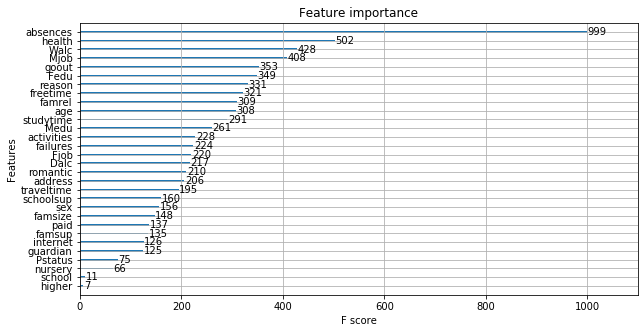

In [14]:
plot_importance(xgb)
plt.rcParams['figure.figsize']=(10,5)
plt.show()

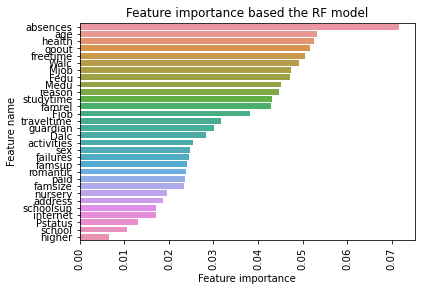

In [25]:
data = pd.read_csv('./student-mat.csv', sep=';')
cats = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
oe = OrdinalEncoder()
for c in cats:
    oe.fit(data[c].values.reshape(-1,1))
    data[c] = np.asarray(oe.transform(data[c].values.reshape(-1,1)),dtype=int)
#     np.asarray(data['gender'],dtype=int)
columns = cats[:-3]
data = data.values
data = shuffle(data)
rfc = RandomForestRegressor(random_state=0)
rfc.fit(data[:,:-3], data[:,-3])
dn = {'features':columns, 'score':rfc.feature_importances_}
df = pd.DataFrame.from_dict(data=dn).sort_values(by='score', ascending=False)
plot = sns.barplot(x='score', y='features', data=df, orient='h')
plot.set(xlabel='Feature importance', ylabel='Feature name')#, title='Feature importance from the RF model'
plt.setp(plot.get_xticklabels(), rotation=90)
plt.show()

# G3

In [22]:
mlps = np.array([[0.79078832, 1.09729382, 1.10843011, 0.98633097],
       [0.81517514, 1.15005579, 1.15831823, 0.98485598],
       [0.78721414, 1.10964661, 1.11977573, 0.98581276],
       [0.79744052, 1.09884692, 1.10865264, 0.98537164],
       [0.79713483, 1.12717005, 1.13452538, 0.98499425],
       [0.82514316, 1.16656086, 1.17388738, 0.98406489],
       [0.81033583, 1.1360358 , 1.14101015, 0.98483475],
       [0.84655335, 1.18246854, 1.1917545 , 0.98378312],
       [0.81770408, 1.13809671, 1.14758059, 0.98497541],
       [0.80353856, 1.12493884, 1.13584471, 0.98522065],
       [0.7954482 , 1.10387246, 1.10828159, 0.98578629],
       [0.80876618, 1.13827854, 1.14687909, 0.98448695],
       [0.83237374, 1.16592367, 1.17251778, 0.98399182],
       [0.78496817, 1.1087211 , 1.12132066, 0.98563161],
       [0.81167466, 1.10030687, 1.11478903, 0.98503533],
       [0.79421926, 1.09530906, 1.10426694, 0.98602024],
       [0.78759038, 1.07668453, 1.08523292, 0.98653027],
       [0.83234862, 1.13846958, 1.14265788, 0.98486285],
       [0.80480877, 1.0882802 , 1.09888594, 0.98606383],
       [0.77592696, 1.0994544 , 1.11124523, 0.985958  ]])
svms = np.array([[0.76216227, 1.04863386, 1.05735946, 0.98662482],
       [0.7487965 , 1.04502922, 1.05302634, 0.98739833],
       [0.7709122 , 1.06200827, 1.07146292, 0.98677459],
       [0.77331201, 1.0559315 , 1.07076082, 0.98689988],
       [0.76603367, 1.05068657, 1.0621524 , 0.98687457],
       [0.75857288, 1.03609673, 1.05218144, 0.98709384],
       [0.76515634, 1.06378477, 1.07281422, 0.98690016],
       [0.76226495, 1.05005342, 1.06219312, 0.98695758],
       [0.75452947, 1.02351297, 1.0346292 , 0.98700455],
       [0.76783115, 1.04736042, 1.05735275, 0.98701527],
       [0.75259532, 1.05318241, 1.06726809, 0.98720432],
       [0.75779105, 1.03525562, 1.04660595, 0.9868721 ],
       [0.77407163, 1.06315504, 1.07532897, 0.98674589],
       [0.76676137, 1.05409325, 1.0736749 , 0.98704804],
       [0.75516964, 1.05268119, 1.05739522, 0.98709604],
       [0.76169217, 1.05723478, 1.06918882, 0.98711077],
       [0.75531758, 1.05157017, 1.06064102, 0.98710241],
       [0.77081674, 1.06880328, 1.08025879, 0.98656584],
       [0.76846653, 1.05020336, 1.06288305, 0.98687208],
       [0.75500574, 1.05687573, 1.06257906, 0.98720089]])
rfs = np.array([[0.72858213, 1.02540662, 1.03698042, 0.98770597],
       [0.73762917, 1.02334107, 1.04156753, 0.98711966],
       [0.72288171, 1.03662636, 1.04176424, 0.98728021],
       [0.72947069, 1.02394603, 1.0343172 , 0.98741076],
       [0.7318178 , 1.04741251, 1.05864285, 0.98730347],
       [0.72612331, 1.0391893 , 1.04822726, 0.9874095 ],
       [0.72150543, 1.01637357, 1.03662967, 0.98783668],
       [0.73940341, 1.05459804, 1.05878476, 0.98702451],
       [0.71988806, 1.01031438, 1.01880963, 0.98777232],
       [0.72514375, 1.04079793, 1.0448773 , 0.98749902],
       [0.7372641 , 1.0578224 , 1.0650701 , 0.98697454],
       [0.72657178, 1.05278573, 1.05552411, 0.98713475],
       [0.72786055, 1.04801947, 1.05819548, 0.98739706],
       [0.72259856, 1.02945573, 1.04376778, 0.98734581],
       [0.71721366, 1.02874628, 1.03299865, 0.9871187 ],
       [0.72584315, 1.04444074, 1.05274898, 0.98733965],
       [0.71993523, 1.02925159, 1.03560901, 0.98776397],
       [0.725432  , 1.04852599, 1.05451144, 0.98695136],
       [0.74257813, 1.05854947, 1.07066554, 0.9866228 ],
       [0.73944076, 1.0367287 , 1.04785351, 0.98694011]])

xgbs = np.array([[0.79969305, 1.11408867, 1.12559916, 0.98589768],
       [0.79431842, 1.12846662, 1.13835826, 0.98490572],
       [0.81896153, 1.14111544, 1.15351048, 0.98486486],
       [0.78948319, 1.10861454, 1.11534055, 0.98556279],
       [0.77353591, 1.08318302, 1.08909616, 0.98626674],
       [0.80298124, 1.12789816, 1.13956679, 0.98528405],
       [0.80574503, 1.1036222 , 1.11523886, 0.98569696],
       [0.82080736, 1.14363031, 1.15337414, 0.9850742 ],
       [0.8142141 , 1.13661227, 1.14743907, 0.98492432],
       [0.7964623 , 1.12397245, 1.14071928, 0.98516982],
       [0.81069919, 1.13498739, 1.14547373, 0.98499366],
       [0.79557973, 1.13124145, 1.14306923, 0.9852297 ],
       [0.789218  , 1.10011496, 1.1039279 , 0.98608386],
       [0.80341453, 1.09830534, 1.11343532, 0.98590693],
       [0.78381294, 1.07662786, 1.08408819, 0.98661669],
       [0.81256494, 1.12397922, 1.13939021, 0.98493593],
       [0.8116259 , 1.13688874, 1.14532018, 0.98515521],
       [0.80055499, 1.11248305, 1.13040022, 0.98540965],
       [0.7853694 , 1.09718951, 1.10338302, 0.98601959],
       [0.81565071, 1.13233428, 1.15106613, 0.98494649]])
cats = np.array([[0.7607876 , 1.07081461, 1.08163184, 0.98627865],
       [0.75333019, 1.06845611, 1.07334192, 0.98658307],
       [0.73719425, 1.00612999, 1.01315801, 0.98785124],
       [0.75348062, 1.0710972 , 1.07820407, 0.98656406],
       [0.73086787, 1.01156261, 1.01483671, 0.98753268],
       [0.74856155, 1.05866989, 1.07330666, 0.98699255],
       [0.74188485, 1.02988038, 1.04063616, 0.9874438 ],
       [0.74784103, 1.0607015 , 1.06691165, 0.98711875],
       [0.75195611, 1.07911908, 1.09015229, 0.98644607],
       [0.74958207, 1.0514737 , 1.06014068, 0.98669458],
       [0.74216261, 1.04732556, 1.05749025, 0.98720007],
       [0.73611822, 1.0430858 , 1.05730695, 0.98706463],
       [0.75724731, 1.07058142, 1.07962737, 0.98675568],
       [0.74829255, 1.063866  , 1.06870772, 0.98724904],
       [0.73250305, 1.04016859, 1.04738748, 0.98750862],
       [0.75266321, 1.04852918, 1.06452594, 0.98680246],
       [0.74851747, 1.04695757, 1.05152871, 0.98708211],
       [0.74753521, 1.03726474, 1.04180314, 0.98713083],
       [0.75233826, 1.05640129, 1.06835644, 0.98692864],
       [0.74987253, 1.02607733, 1.0446099 , 0.98741257]])
ccats = np.array([[0.73172087, 1.02012446, 1.03729315, 0.98738658],
       [0.70439686, 0.99022157, 0.99650811, 0.98851429],
       [0.69788628, 0.97333973, 0.98164016, 0.98852148],
       [0.73469545, 1.04833049, 1.05371143, 0.98678666],
       [0.73677586, 1.03651886, 1.04638263, 0.98730323],
       [0.70650262, 0.97749727, 0.98508927, 0.98868344],
       [0.71698385, 1.02446125, 1.02889083, 0.98751082],
       [0.7102275 , 0.99222781, 1.00068598, 0.98860705],
       [0.71627314, 1.01999884, 1.02580227, 0.98799708],
       [0.71778814, 1.00233733, 1.01122714, 0.98820171],
       [0.72071872, 1.01401425, 1.02110258, 0.98801301],
       [0.71161727, 1.01140177, 1.02065822, 0.98804811],
       [0.73133469, 1.05069836, 1.05700305, 0.98697243],
       [0.71848096, 1.00766   , 1.01979891, 0.98812742],
       [0.71979889, 1.03419955, 1.04555757, 0.98775624],
       [0.73282142, 1.04211805, 1.04998614, 0.98707389],
       [0.7258568 , 1.03330256, 1.04012936, 0.98745435],
       [0.7084359 , 1.00552327, 1.02045446, 0.98815402],
       [0.70933522, 0.99800745, 1.00311138, 0.98789508],
       [0.73944693, 1.03036909, 1.04778842, 0.98732532]])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


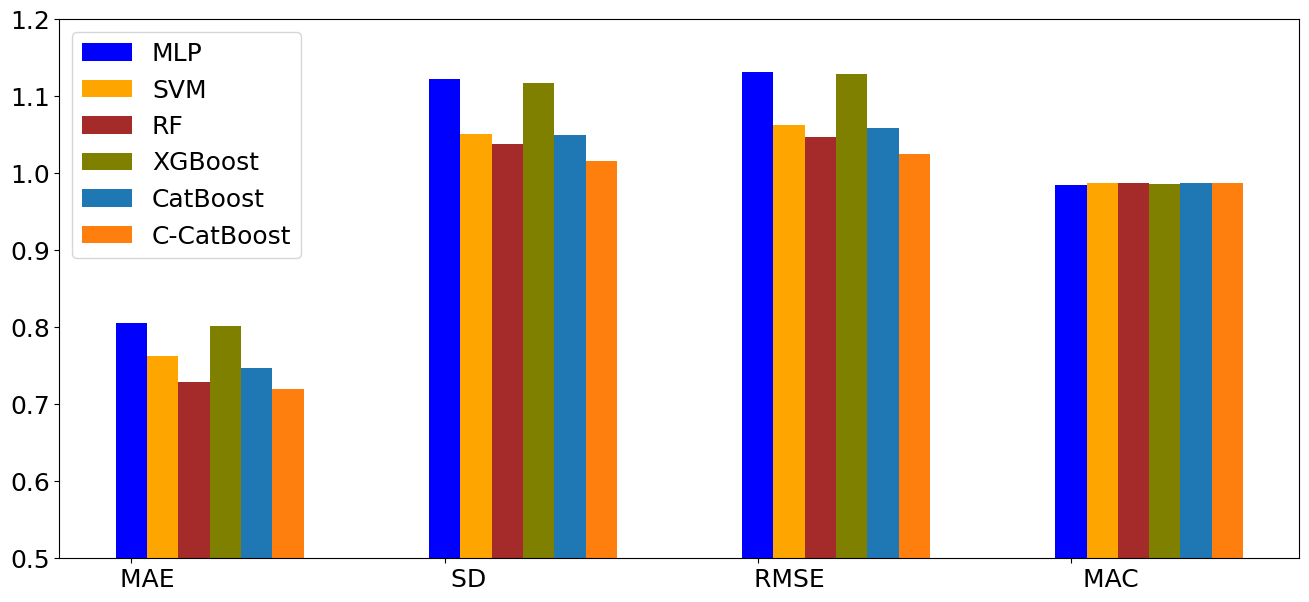

In [4]:
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt


mlp = np.mean(mlps, axis=0)
svm = np.mean(svms, axis=0)
rf = np.mean(rfs, axis=0)
xgb = np.mean(xgbs, axis=0)
cat = np.mean(cats, axis=0)
ccat = np.mean(ccats, axis=0)
names = ['    MAE', '      SD','        RMSE','          MAC']

figure(num=None, figsize=(16, 7))
y_pos=np.arange(len(names))
plt.bar(y_pos + 0, mlp,width=0.1, color = 'blue' , label='MLP')
plt.bar(y_pos + 0.1, svm,width=0.1, color = 'orange' , label='SVM')
plt.bar(y_pos + 0.2, rf,width=0.1, color = 'brown' , label='RF')
plt.bar(y_pos + 0.3, xgb,width=0.1, color = 'olive' , label='XGBoost')
plt.bar(y_pos + 0.4, cat,width=0.1, label='CatBoost')
plt.bar(y_pos + 0.5, ccat,width=0.1, label='C-CatBoost')

font = {
#     'family' : 'Times New Roman',
#         'weight' : 'bold',
        'size'   : 18}
plt.rcParams.update({'font.size': 18})
plt.rc('font', **font)
plt.ylim(0.5, 1.2)
plt.xticks(y_pos, names)
plt.legend(('MLP', 'SVM','RF','XGBoost','CatBoost','C-CatBoost'),loc='upper left')
plt.savefig('porG3C.eps', format='eps',bbox_inches='tight')
# plt.title("Put a title here")
plt.show()

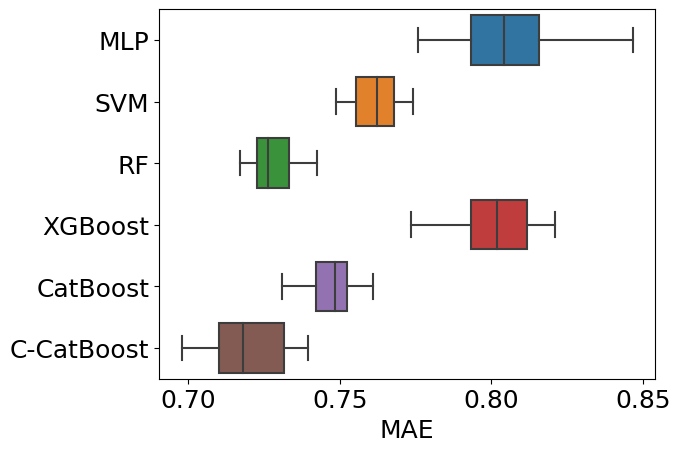

In [5]:
df = pd.DataFrame(columns=['MLP', 'SVM',"RF","XGBoost","CatBoost",'C-CatBoost'])
i = 0
df["MLP"] = mlps[:, i]
df["SVM"] = svms[:, i]
df["RF"] = rfs[:, i]
df["XGBoost"] = xgbs[:, i]
df["CatBoost"] = cats[:, i]
df["C-CatBoost"] = ccats[:, i]
ax = sns.boxplot(data=df,orient='h')#, x=x, y=y, hue=hue
# add_stat_annotation(ax, data=df,
#                     box_pairs=[("ANN", "FW-LS-SVM"), ("SVM", "FW-LS-SVM"),
#                                  ("LS-SVM", "FW-LS-SVM")
#                                 ],
#                     test='t-test_ind', text_format='full', loc='inside', verbose=2)
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
ax.set(xlabel="MAE")

# plt.savefig('ensembleUCI.eps', format='eps')
plt.savefig('porMAEG3.eps', format='eps',bbox_inches  ='tight')

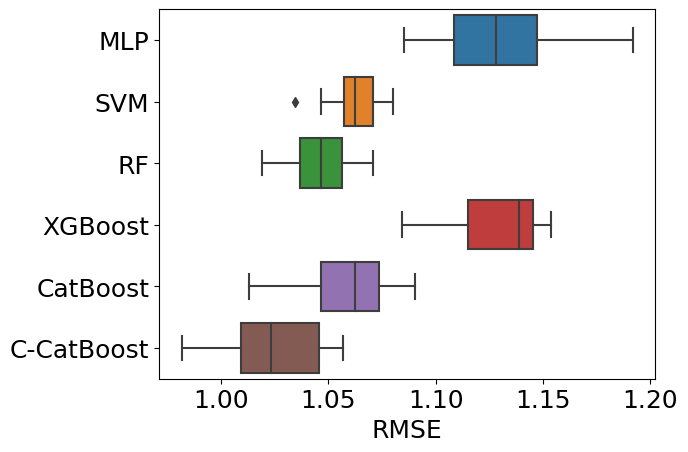

In [6]:
df = pd.DataFrame(columns=['MLP', 'SVM',"RF","XGBoost","CatBoost",'C-CatBoost'])
i = 2
df["MLP"] = mlps[:, i]
df["SVM"] = svms[:, i]
df["RF"] = rfs[:, i]
df["XGBoost"] = xgbs[:, i]
df["CatBoost"] = cats[:, i]
df["C-CatBoost"] = ccats[:, i]
ax = sns.boxplot(data=df,orient='h')#, x=x, y=y, hue=hue
# add_stat_annotation(ax, data=df,
#                     box_pairs=[("ANN", "FW-LS-SVM"), ("SVM", "FW-LS-SVM"),
#                                  ("LS-SVM", "FW-LS-SVM")
#                                 ],
#                     test='t-test_ind', text_format='full', loc='inside', verbose=2)
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
ax.set(xlabel="RMSE")

# plt.savefig('ensembleUCI.eps', format='eps')
plt.savefig('porRMSEG3.eps', format='eps',bbox_inches  ='tight')

In [23]:
# for i in range(4):
#     print(ranksums(mlp[:,i], svm[:,i]).pvalue)
# i=0
for i in range(4):
    print(ranksums(ccats[:,i], mlps[:,i]).pvalue)
    print(ranksums(ccats[:,i], svms[:,i]).pvalue)
    print(ranksums(ccats[:,i], rfs[:,i]).pvalue)
    print(ranksums(ccats[:,i], xgbs[:,i]).pvalue)
    print(ranksums(ccats[:,i], cats[:,i]).pvalue)
    print()


6.301848221392269e-08
6.301848221392269e-08
0.011881031549672502
6.301848221392269e-08
4.2286279422220743e-07

6.301848221392269e-08
1.928120924930404e-06
0.0018660638566261292
6.301848221392269e-08
5.566702833736114e-05

6.301848221392269e-08
6.450519799610879e-07
0.0024486973708739636
6.301848221392269e-08
6.24351207659815e-05

6.301848221392269e-08
9.15545783239678e-06
0.00348451363809075
6.301848221392269e-08
0.00010965847586374337



# G2

In [20]:
mlps = np.array([[1.04023485, 1.32620649, 1.33480298, 0.97289575],
       [1.06997869, 1.36108037, 1.37756531, 0.97153563],
       [1.05997615, 1.34682715, 1.35686477, 0.9713821 ],
       [1.08064917, 1.39039014, 1.39709083, 0.97011804],
       [1.09902194, 1.40156276, 1.40768018, 0.96909768],
       [1.07701104, 1.37103385, 1.38799958, 0.97097981],
       [1.06431715, 1.34811983, 1.35418644, 0.97205599],
       [1.10728698, 1.40020282, 1.42252619, 0.96967162],
       [1.08069341, 1.36430569, 1.37311403, 0.9709757 ],
       [1.04030396, 1.30249507, 1.33114267, 0.97337256],
       [1.05272337, 1.34528118, 1.37300711, 0.97190485],
       [1.10111533, 1.40326452, 1.41169136, 0.96971674],
       [1.09761997, 1.3647538 , 1.37853669, 0.97098635],
       [1.0082648 , 1.29102812, 1.29695881, 0.97393289],
       [1.08616297, 1.3714384 , 1.38334382, 0.97056522],
       [1.06859636, 1.36486478, 1.37908486, 0.97105421],
       [1.07105132, 1.35456039, 1.36704711, 0.97157829],
       [1.04958491, 1.32223477, 1.34755976, 0.97253984],
       [1.06262493, 1.35478336, 1.36718537, 0.9717944 ],
       [1.04745216, 1.31962393, 1.34091904, 0.9725072 ]])
svms = np.array([[0.95709641, 1.25437285, 1.26158576, 0.97595299],
       [0.97302425, 1.26310417, 1.28060118, 0.97514628],
       [0.94826963, 1.23738932, 1.24510214, 0.97600696],
       [0.95882534, 1.25239717, 1.25942122, 0.97564607],
       [0.95473307, 1.24414418, 1.26196028, 0.9761955 ],
       [0.95779684, 1.231285  , 1.25828045, 0.97638815],
       [0.95899595, 1.24727454, 1.258235  , 0.97535298],
       [0.96112097, 1.23451556, 1.26228145, 0.97552738],
       [0.95039717, 1.24131201, 1.25205062, 0.9759756 ],
       [0.96685091, 1.25608187, 1.26824134, 0.97564605],
       [0.9544931 , 1.24632403, 1.2604084 , 0.97598153],
       [0.94409161, 1.23111628, 1.2383457 , 0.97633984],
       [0.94455715, 1.2406196 , 1.24765389, 0.97587165],
       [0.96479168, 1.24289073, 1.26501095, 0.97571177],
       [0.95708705, 1.24660143, 1.25530297, 0.97539685],
       [0.9536248 , 1.24237282, 1.25440579, 0.97567052],
       [0.96937456, 1.26114217, 1.26573429, 0.97492066],
       [0.9676706 , 1.26194408, 1.26975562, 0.97514462],
       [0.95799953, 1.24034008, 1.25643983, 0.97603511],
       [0.96223014, 1.24673382, 1.26257067, 0.9755595 ]])
rfs = np.array([[0.99282719, 1.27443999, 1.27891651, 0.97451761],
       [0.99115089, 1.27671423, 1.28248512, 0.97483101],
       [0.9867866 , 1.26625588, 1.27819058, 0.97527013],
       [0.99357889, 1.25942458, 1.27699669, 0.97533906],
       [0.98913176, 1.27617091, 1.27868909, 0.97463112],
       [0.99877515, 1.28197682, 1.29725563, 0.97449022],
       [0.98731276, 1.26417227, 1.27769668, 0.97478484],
       [1.00211564, 1.28868357, 1.29788829, 0.97435738],
       [1.00065571, 1.2876907 , 1.29437318, 0.97436787],
       [0.98539594, 1.26235029, 1.2698734 , 0.9754233 ],
       [0.99228661, 1.26450317, 1.27434574, 0.97504523],
       [0.97100555, 1.24379162, 1.24977218, 0.97607354],
       [0.98793193, 1.26289955, 1.26655198, 0.975431  ],
       [0.99942703, 1.27817158, 1.29346105, 0.97450555],
       [0.99415515, 1.27939749, 1.28817289, 0.97464072],
       [0.98340293, 1.26846078, 1.27218373, 0.97501062],
       [0.98077594, 1.26570648, 1.27157856, 0.97553819],
       [0.99207001, 1.26643745, 1.28007915, 0.97532405],
       [0.99476985, 1.27213534, 1.28289831, 0.97505865],
       [0.99319149, 1.2624285 , 1.26928712, 0.97487249]])
xgbs = np.array([[1.09392733, 1.36245995, 1.37867556, 0.97137721],
       [1.13100161, 1.41777953, 1.43375583, 0.96870658],
       [1.06365288, 1.35055546, 1.35850615, 0.9718969 ],
       [1.08923772, 1.37631882, 1.39126913, 0.97086895],
       [1.10074903, 1.38633466, 1.39956245, 0.96997499],
       [1.07238935, 1.35069799, 1.36646206, 0.97197852],
       [1.07257382, 1.37117063, 1.37688768, 0.97054142],
       [1.09662205, 1.39315211, 1.40253367, 0.97000698],
       [1.0951814 , 1.38958966, 1.39735749, 0.96997437],
       [1.07418738, 1.36083991, 1.37623991, 0.97135796],
       [1.06401733, 1.33465551, 1.33948142, 0.97211657],
       [1.10313738, 1.39263552, 1.39974644, 0.9699506 ],
       [1.06314335, 1.35915021, 1.3676756 , 0.97166338],
       [1.06775299, 1.34849384, 1.35840156, 0.97195856],
       [1.04100878, 1.32489001, 1.33160173, 0.97245144],
       [1.09861702, 1.37893283, 1.39501497, 0.97032742],
       [1.08501403, 1.37675622, 1.38819102, 0.97005542],
       [1.06196416, 1.35334399, 1.36022804, 0.97122295],
       [1.0640848 , 1.34366956, 1.35713845, 0.97205907],
       [1.08469938, 1.38834192, 1.39880399, 0.96992218]])
cats = np.array([[0.97429917, 1.24318798, 1.24858339, 0.97598056],
       [0.98101609, 1.24493192, 1.25676401, 0.97586296],
       [0.9697546 , 1.24803116, 1.25668759, 0.97593737],
       [0.96534394, 1.22793292, 1.23778557, 0.97662623],
       [0.97370403, 1.25191903, 1.25510606, 0.97561919],
       [0.97252534, 1.24304088, 1.25166013, 0.97631312],
       [0.97941117, 1.24371544, 1.25725181, 0.97541677],
       [0.97337167, 1.24641969, 1.25995194, 0.97554393],
       [0.96626634, 1.23896792, 1.24311059, 0.97616259],
       [0.98137816, 1.23612736, 1.25698412, 0.97621274],
       [0.98199611, 1.25840045, 1.26548276, 0.97555087],
       [0.97021727, 1.23471928, 1.2462402 , 0.97635551],
       [0.96976469, 1.2419331 , 1.25914829, 0.97565813],
       [0.97519234, 1.25028767, 1.26366069, 0.97572093],
       [0.9743517 , 1.25977157, 1.26644634, 0.97547598],
       [0.99431063, 1.25825511, 1.27177022, 0.97546462],
       [0.98425873, 1.26722377, 1.27597417, 0.97510106],
       [0.9864173 , 1.25781246, 1.26908986, 0.97571471],
       [0.98715271, 1.24330438, 1.27609994, 0.97585372],
       [1.00427825, 1.28563874, 1.29578638, 0.9743339 ]])
ccats = np.array([[0.93831791, 1.21568443, 1.21926568, 0.97660896],
       [0.90309166, 1.13791594, 1.15508359, 0.9788999 ],
       [0.96865009, 1.2254814 , 1.23733253, 0.97551225],
       [0.92552299, 1.18534343, 1.20044502, 0.97705231],
       [0.91935535, 1.19171247, 1.19786467, 0.97684815],
       [0.92944697, 1.16687465, 1.18085255, 0.97747908],
       [0.90653083, 1.15197501, 1.16612775, 0.97878491],
       [0.92032723, 1.17762458, 1.18234004, 0.97770552],
       [0.94511378, 1.18900012, 1.19973796, 0.97617199],
       [0.93460384, 1.2127158 , 1.22090494, 0.97631673],
       [0.9192153 , 1.19134208, 1.19834823, 0.97685601],
       [0.92796759, 1.18514573, 1.19088421, 0.97705837],
       [0.94270672, 1.18168422, 1.18971112, 0.97698483],
       [0.94021467, 1.18335464, 1.18889577, 0.9765981 ],
       [0.92938878, 1.18443875, 1.19584478, 0.9774597 ],
       [0.94610316, 1.20495114, 1.2137383 , 0.97619214],
       [0.93251095, 1.19892415, 1.20610387, 0.97658828],
       [0.93543642, 1.18110461, 1.19014259, 0.97704185],
       [0.91595608, 1.18229479, 1.18804203, 0.97742931],
       [0.9247085 , 1.16316765, 1.18344443, 0.97801535]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


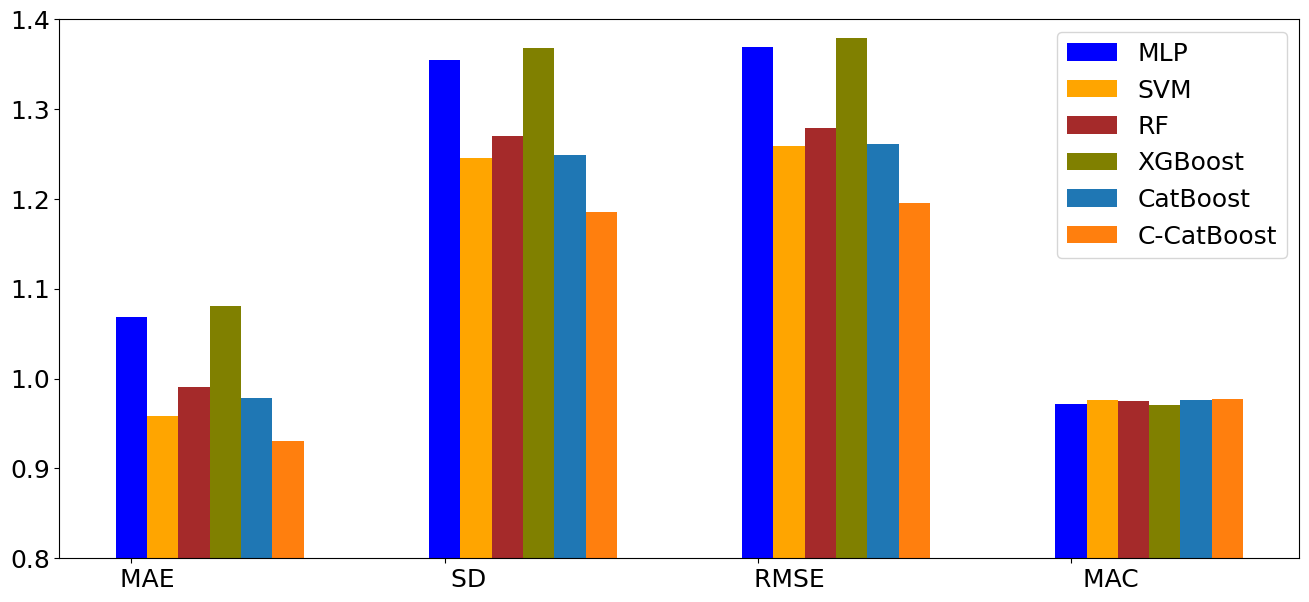

In [10]:
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt


mlp = np.mean(mlps, axis=0)
svm = np.mean(svms, axis=0)
rf = np.mean(rfs, axis=0)
xgb = np.mean(xgbs, axis=0)
cat = np.mean(cats, axis=0)
ccat = np.mean(ccats, axis=0)
names = ['    MAE', '      SD','        RMSE','          MAC']

figure(num=None, figsize=(16, 7))
y_pos=np.arange(len(names))
plt.bar(y_pos + 0, mlp,width=0.1, color = 'blue' , label='MLP')
plt.bar(y_pos + 0.1, svm,width=0.1, color = 'orange' , label='SVM')
plt.bar(y_pos + 0.2, rf,width=0.1, color = 'brown' , label='RF')
plt.bar(y_pos + 0.3, xgb,width=0.1, color = 'olive' , label='XGBoost')
plt.bar(y_pos + 0.4, cat,width=0.1, label='CatBoost')
plt.bar(y_pos + 0.5, ccat,width=0.1, label='C-CatBoost')

font = {
#     'family' : 'Times New Roman',
#         'weight' : 'bold',
        'size'   : 18}
plt.rcParams.update({'font.size': 18})
plt.rc('font', **font)
plt.ylim(0.8, 1.4)
plt.xticks(y_pos, names)
plt.legend(('MLP', 'SVM','RF','XGBoost','CatBoost','C-CatBoost'),loc='upper right')
plt.savefig('porG2C.eps', format='eps',bbox_inches='tight')
# plt.title("Put a title here")
plt.show()

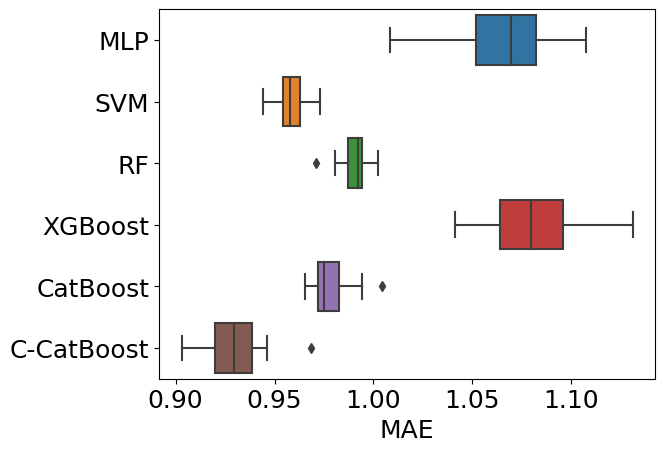

In [11]:
df = pd.DataFrame(columns=['MLP', 'SVM',"RF","XGBoost","CatBoost",'C-CatBoost'])
i = 0
df["MLP"] = mlps[:, i]
df["SVM"] = svms[:, i]
df["RF"] = rfs[:, i]
df["XGBoost"] = xgbs[:, i]
df["CatBoost"] = cats[:, i]
df["C-CatBoost"] = ccats[:, i]
ax = sns.boxplot(data=df,orient='h')#, x=x, y=y, hue=hue
# add_stat_annotation(ax, data=df,
#                     box_pairs=[("ANN", "FW-LS-SVM"), ("SVM", "FW-LS-SVM"),
#                                  ("LS-SVM", "FW-LS-SVM")
#                                 ],
#                     test='t-test_ind', text_format='full', loc='inside', verbose=2)
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
ax.set(xlabel="MAE")

# plt.savefig('ensembleUCI.eps', format='eps')
plt.savefig('porMAEG2.eps', format='eps',bbox_inches  ='tight')

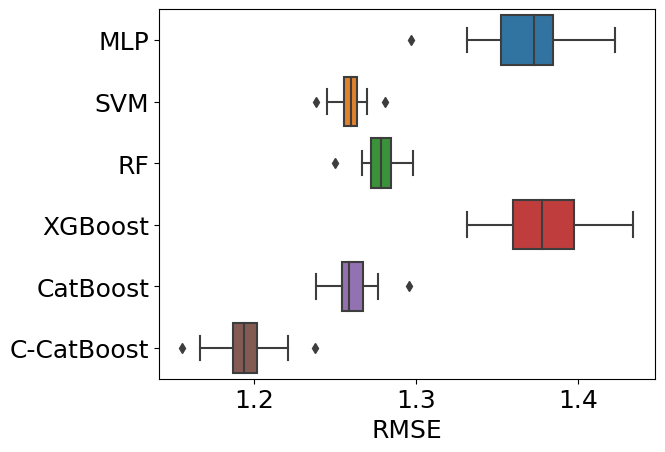

In [12]:
df = pd.DataFrame(columns=['MLP', 'SVM',"RF","XGBoost","CatBoost",'C-CatBoost'])
i = 2
df["MLP"] = mlps[:, i]
df["SVM"] = svms[:, i]
df["RF"] = rfs[:, i]
df["XGBoost"] = xgbs[:, i]
df["CatBoost"] = cats[:, i]
df["C-CatBoost"] = ccats[:, i]
ax = sns.boxplot(data=df,orient='h')#, x=x, y=y, hue=hue
# add_stat_annotation(ax, data=df,
#                     box_pairs=[("ANN", "FW-LS-SVM"), ("SVM", "FW-LS-SVM"),
#                                  ("LS-SVM", "FW-LS-SVM")
#                                 ],
#                     test='t-test_ind', text_format='full', loc='inside', verbose=2)
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
ax.set(xlabel="RMSE")

# plt.savefig('ensembleUCI.eps', format='eps')
plt.savefig('porRMSEG2.eps', format='eps',bbox_inches  ='tight')

In [21]:
# for i in range(4):
#     print(ranksums(mlp[:,i], svm[:,i]).pvalue)
# i=0
for i in range(4):
    print(ranksums(ccats[:,i], mlps[:,i]).pvalue)
    print(ranksums(ccats[:,i], svms[:,i]).pvalue)
    print(ranksums(ccats[:,i], rfs[:,i]).pvalue)
    print(ranksums(ccats[:,i], xgbs[:,i]).pvalue)
    print(ranksums(ccats[:,i], cats[:,i]).pvalue)
    print()


6.301848221392269e-08
1.4726193365861273e-06
6.301848221392269e-08
6.301848221392269e-08
8.512328416895721e-08

6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08

6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08

6.301848221392269e-08
1.6856433537154655e-06
8.512328416895721e-08
6.301848221392269e-08
3.2775134136970867e-06



# G1

In [18]:
mlps = np.array([[1.90092199, 2.38441685, 2.40798968, 0.92622893],
       [1.92726283, 2.41505527, 2.42923529, 0.92433011],
       [1.95525024, 2.41583629, 2.45389897, 0.92397708],
       [1.90862693, 2.39580409, 2.41672025, 0.9256323 ],
       [1.97577544, 2.43596307, 2.47380387, 0.9237593 ],
       [1.9213361 , 2.40771064, 2.41325975, 0.92579803],
       [1.9135646 , 2.38453556, 2.4060101 , 0.9271011 ],
       [1.88954738, 2.37971089, 2.39484069, 0.92746039],
       [1.97704991, 2.44084814, 2.45547919, 0.92292139],
       [1.94185436, 2.41839639, 2.43776217, 0.92468314],
       [1.96563079, 2.44697776, 2.48888686, 0.92255055],
       [1.93063506, 2.41369427, 2.43773422, 0.92464236],
       [1.88370206, 2.38610103, 2.41379255, 0.92594373],
       [1.970513  , 2.45993981, 2.49708205, 0.9209933 ],
       [1.89223931, 2.38510372, 2.39868796, 0.92610412],
       [2.0123849 , 2.5171212 , 2.53295641, 0.91829392],
       [1.93935203, 2.42514104, 2.43986055, 0.92363494],
       [2.01430845, 2.49415015, 2.51004073, 0.92022426],
       [1.98282925, 2.48167373, 2.50459586, 0.92018376],
       [1.94841312, 2.39978732, 2.42335622, 0.92632034]])
svms = np.array([[1.81037951, 2.28872913, 2.30490276, 0.93250508],
       [1.80810813, 2.28254022, 2.30183341, 0.93323636],
       [1.82456579, 2.29544823, 2.30812283, 0.93173971],
       [1.81984673, 2.30526339, 2.31657785, 0.93133388],
       [1.83812598, 2.32875109, 2.33913275, 0.9303028 ],
       [1.82240652, 2.30278398, 2.32445016, 0.93154845],
       [1.84018535, 2.31067868, 2.33138044, 0.93120136],
       [1.82985361, 2.31905214, 2.32724769, 0.93087501],
       [1.815382  , 2.30235136, 2.31557641, 0.93159672],
       [1.82796413, 2.31531391, 2.33047667, 0.93110387],
       [1.82527495, 2.31030623, 2.32670006, 0.93131394],
       [1.82048164, 2.2925084 , 2.3164214 , 0.93253093],
       [1.82902595, 2.28734637, 2.32325639, 0.9323964 ],
       [1.81714363, 2.30699787, 2.32147505, 0.93136749],
       [1.81957205, 2.2838975 , 2.31169521, 0.93210796],
       [1.81793459, 2.27645537, 2.30586501, 0.93213998],
       [1.82778482, 2.28463598, 2.31234784, 0.93223053],
       [1.82581894, 2.29738928, 2.32722034, 0.931802  ],
       [1.81466113, 2.29344103, 2.31401802, 0.93194232],
       [1.83743906, 2.31705913, 2.33805233, 0.93053662]])
rfs = np.array([[1.80526168, 2.2525983 , 2.27613443, 0.93458957],
       [1.79961302, 2.25643537, 2.27367522, 0.9337531 ],
       [1.80559227, 2.27193105, 2.27623219, 0.93280356],
       [1.81991421, 2.25419919, 2.28426831, 0.93403991],
       [1.79407118, 2.25543066, 2.26533553, 0.93374244],
       [1.77360962, 2.238828  , 2.25315731, 0.93520694],
       [1.80311286, 2.25711924, 2.27164211, 0.93360646],
       [1.79924726, 2.25450221, 2.27287739, 0.93358885],
       [1.80402775, 2.25457923, 2.28088127, 0.93462249],
       [1.81183015, 2.26946236, 2.28158299, 0.93373099],
       [1.80810732, 2.27195633, 2.28612527, 0.9334359 ],
       [1.80775597, 2.26987371, 2.27834376, 0.93321319],
       [1.8036762 , 2.26160923, 2.27958274, 0.93381336],
       [1.81108011, 2.27690555, 2.29055048, 0.93298997],
       [1.82004427, 2.25538095, 2.29409498, 0.93397106],
       [1.78098405, 2.23511297, 2.24479362, 0.93574513],
       [1.78161604, 2.2422559 , 2.25849976, 0.9351739 ],
       [1.82251211, 2.27821134, 2.29653066, 0.93288361],
       [1.81761038, 2.27315458, 2.30449022, 0.93308761],
       [1.81696167, 2.24279525, 2.28992094, 0.93443784]])
xgbs = np.array([[1.95022949, 2.41027276, 2.42872502, 0.92558796],
       [1.92351222, 2.39963668, 2.42262365, 0.92566778],
       [1.96807641, 2.44901267, 2.47373614, 0.92291007],
       [1.93315771, 2.43675921, 2.44831008, 0.92344603],
       [1.99537492, 2.51393557, 2.52484553, 0.91840776],
       [1.91395969, 2.35992372, 2.37718279, 0.92825139],
       [1.98111611, 2.46326702, 2.50231635, 0.92183329],
       [1.93064449, 2.42102765, 2.4471088 , 0.92452672],
       [1.97058761, 2.45396459, 2.46354394, 0.92299806],
       [1.9587583 , 2.40753201, 2.43178598, 0.92481464],
       [1.98779532, 2.52590194, 2.53418503, 0.91826161],
       [2.00623985, 2.49581454, 2.5085061 , 0.91968744],
       [1.99891651, 2.49632967, 2.51546914, 0.9199149 ],
       [1.97278301, 2.45703113, 2.47016205, 0.92194296],
       [1.95607387, 2.40445418, 2.4532266 , 0.92508551],
       [1.96112632, 2.44635921, 2.47976441, 0.92321889],
       [1.96485286, 2.45951179, 2.4933396 , 0.92251675],
       [1.92981439, 2.41912643, 2.4327628 , 0.92503329],
       [1.94853366, 2.41376632, 2.43987905, 0.9246654 ],
       [1.93275556, 2.42011967, 2.43793222, 0.92462798]])

cats = np.array([[1.79472142, 2.27880699, 2.28445816, 0.93317876],
       [1.82926076, 2.29889315, 2.30791815, 0.93223702],
       [1.80547625, 2.26373436, 2.28752999, 0.93339208],
       [1.82126507, 2.27635604, 2.31504201, 0.9326349 ],
       [1.81667203, 2.27702167, 2.30324541, 0.93271615],
       [1.79896977, 2.27284796, 2.29497288, 0.93281957],
       [1.79038291, 2.2546106 , 2.28661307, 0.93418272],
       [1.81017425, 2.2828387 , 2.29260398, 0.93250227],
       [1.86401455, 2.35302194, 2.36101708, 0.92915908],
       [1.83187457, 2.30961322, 2.32195017, 0.9313539 ],
       [1.82690132, 2.27581584, 2.29897352, 0.93303629],
       [1.78098311, 2.22896919, 2.24887363, 0.93445936],
       [1.83646584, 2.30344899, 2.32387577, 0.93171914],
       [1.83668514, 2.32040307, 2.33096101, 0.93007403],
       [1.80263467, 2.27845877, 2.29516732, 0.93245614],
       [1.82844204, 2.2906668 , 2.31143245, 0.93158983],
       [1.82622485, 2.29285846, 2.32345536, 0.9311681 ],
       [1.84415339, 2.32541848, 2.34313316, 0.93055053],
       [1.81243187, 2.30025439, 2.31373868, 0.93171503],
       [1.81999536, 2.28452077, 2.31610045, 0.93333095]])

ccats = np.array([[1.71607634, 2.13653231, 2.15498886, 0.93906919],
       [1.75005822, 2.20948429, 2.22776984, 0.9351554 ],
       [1.72597774, 2.17251759, 2.17704303, 0.93674955],
       [1.72254786, 2.16496072, 2.17284897, 0.93801766],
       [1.74821271, 2.17302355, 2.18326281, 0.93670767],
       [1.75765137, 2.18459141, 2.2081468 , 0.93559562],
       [1.76608113, 2.21177336, 2.23910567, 0.9338085 ],
       [1.6913577 , 2.14782639, 2.15786437, 0.93773438],
       [1.75857429, 2.1752275 , 2.19935064, 0.93566252],
       [1.73448238, 2.20172135, 2.21006849, 0.93496995],
       [1.73057761, 2.16949231, 2.19538105, 0.93652676],
       [1.77500405, 2.2196177 , 2.22836511, 0.9333052 ],
       [1.71082193, 2.16011051, 2.17385873, 0.93679416],
       [1.72089467, 2.19056266, 2.20723992, 0.93522737],
       [1.7586119 , 2.22150119, 2.24416778, 0.93367808],
       [1.74479597, 2.20601715, 2.21998769, 0.93445437],
       [1.74273082, 2.15307625, 2.16774201, 0.93701469],
       [1.74543647, 2.20765439, 2.21975846, 0.93532375],
       [1.75265015, 2.18998286, 2.20016099, 0.93583249],
       [1.70227484, 2.14860406, 2.16271576, 0.93855049]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


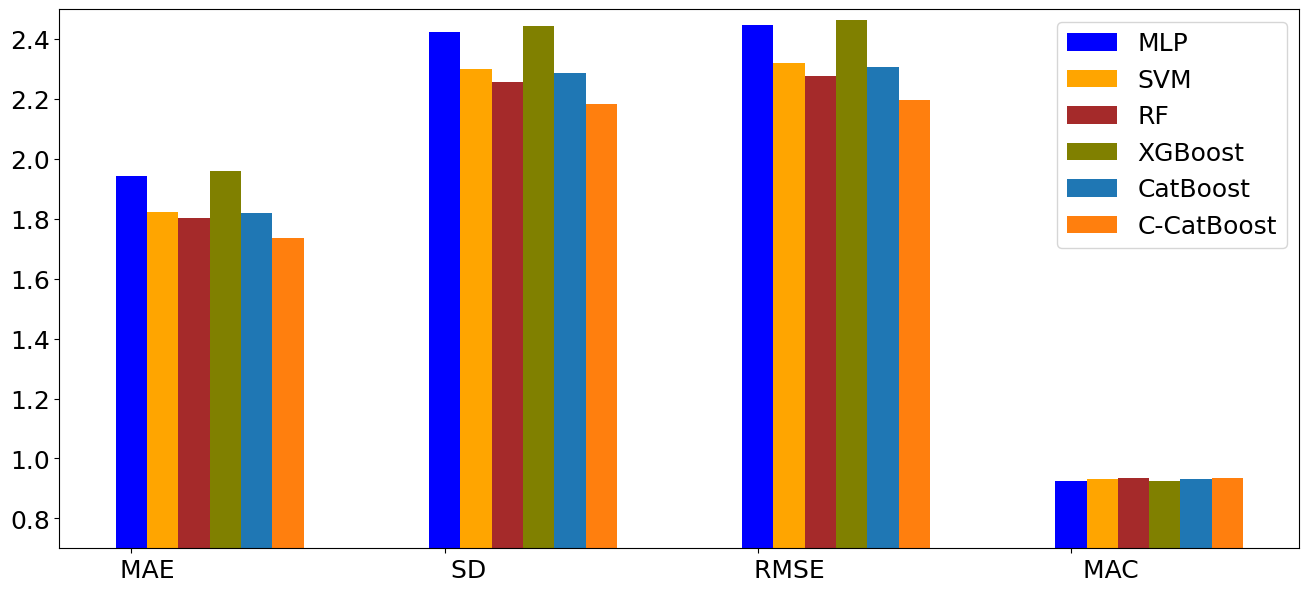

In [15]:
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt


mlp = np.mean(mlps, axis=0)
svm = np.mean(svms, axis=0)
rf = np.mean(rfs, axis=0)
xgb = np.mean(xgbs, axis=0)
cat = np.mean(cats, axis=0)
ccat = np.mean(ccats, axis=0)
names = ['    MAE', '      SD','        RMSE','          MAC']

figure(num=None, figsize=(16, 7))
y_pos=np.arange(len(names))
plt.bar(y_pos + 0, mlp,width=0.1, color = 'blue' , label='MLP')
plt.bar(y_pos + 0.1, svm,width=0.1, color = 'orange' , label='SVM')
plt.bar(y_pos + 0.2, rf,width=0.1, color = 'brown' , label='RF')
plt.bar(y_pos + 0.3, xgb,width=0.1, color = 'olive' , label='XGBoost')
plt.bar(y_pos + 0.4, cat,width=0.1, label='CatBoost')
plt.bar(y_pos + 0.5, ccat,width=0.1, label='C-CatBoost')

font = {
#     'family' : 'Times New Roman',
#         'weight' : 'bold',
        'size'   : 18}
plt.rcParams.update({'font.size': 18})
plt.rc('font', **font)
plt.ylim(0.7, 2.5)
plt.xticks(y_pos, names)
plt.legend(('MLP', 'SVM','RF','XGBoost','CatBoost','C-CatBoost'),loc='upper right')
plt.savefig('porG1C.eps', format='eps',bbox_inches='tight')
# plt.title("Put a title here")
plt.show()

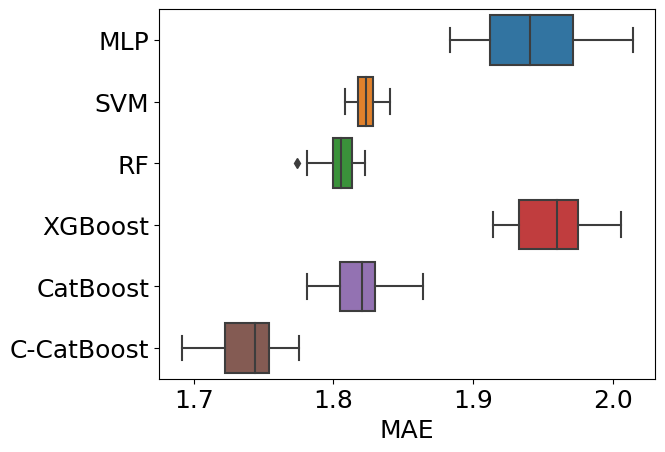

In [16]:
df = pd.DataFrame(columns=['MLP', 'SVM',"RF","XGBoost","CatBoost",'C-CatBoost'])
i = 0
df["MLP"] = mlps[:, i]
df["SVM"] = svms[:, i]
df["RF"] = rfs[:, i]
df["XGBoost"] = xgbs[:, i]
df["CatBoost"] = cats[:, i]
df["C-CatBoost"] = ccats[:, i]
ax = sns.boxplot(data=df,orient='h')#, x=x, y=y, hue=hue
# add_stat_annotation(ax, data=df,
#                     box_pairs=[("ANN", "FW-LS-SVM"), ("SVM", "FW-LS-SVM"),
#                                  ("LS-SVM", "FW-LS-SVM")
#                                 ],
#                     test='t-test_ind', text_format='full', loc='inside', verbose=2)
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
ax.set(xlabel="MAE")

# plt.savefig('ensembleUCI.eps', format='eps')
plt.savefig('porMAEG1.eps', format='eps',bbox_inches  ='tight')

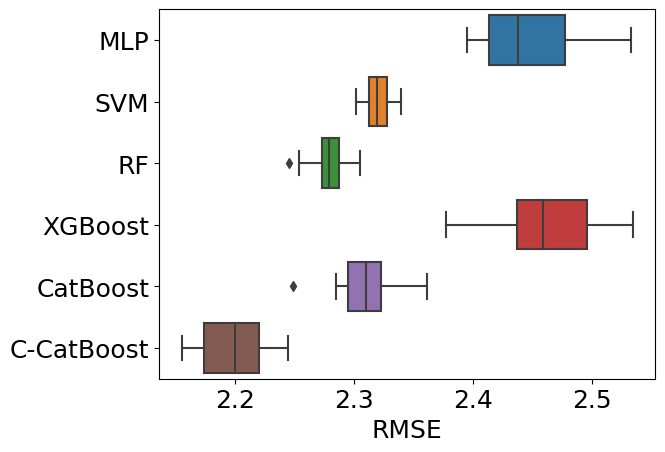

In [17]:
df = pd.DataFrame(columns=['MLP', 'SVM',"RF","XGBoost","CatBoost",'C-CatBoost'])
i = 2
df["MLP"] = mlps[:, i]
df["SVM"] = svms[:, i]
df["RF"] = rfs[:, i]
df["XGBoost"] = xgbs[:, i]
df["CatBoost"] = cats[:, i]
df["C-CatBoost"] = ccats[:, i]
ax = sns.boxplot(data=df,orient='h')#, x=x, y=y, hue=hue
# add_stat_annotation(ax, data=df,
#                     box_pairs=[("ANN", "FW-LS-SVM"), ("SVM", "FW-LS-SVM"),
#                                  ("LS-SVM", "FW-LS-SVM")
#                                 ],
#                     test='t-test_ind', text_format='full', loc='inside', verbose=2)
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
ax.set(xlabel="RMSE")

# plt.savefig('ensembleUCI.eps', format='eps')
plt.savefig('porRMSEG1.eps', format='eps',bbox_inches  ='tight')

In [19]:
# for i in range(4):
#     print(ranksums(mlp[:,i], svm[:,i]).pvalue)
# i=0
for i in range(4):
    print(ranksums(ccats[:,i], mlps[:,i]).pvalue)
    print(ranksums(ccats[:,i], svms[:,i]).pvalue)
    print(ranksums(ccats[:,i], rfs[:,i]).pvalue)
    print(ranksums(ccats[:,i], xgbs[:,i]).pvalue)
    print(ranksums(ccats[:,i], cats[:,i]).pvalue)
    print()


6.301848221392269e-08
6.301848221392269e-08
7.32676819947719e-08
6.301848221392269e-08
6.301848221392269e-08

6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08

6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08

6.301848221392269e-08
6.301848221392269e-08
5.566702833736114e-05
6.301848221392269e-08
2.3843274880841985e-07

